In [73]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np
import json
import argparse
import torch
from torch.optim import lr_scheduler
from tqdm import tqdm
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from trainer import Trainer
from utils import Logger
from utils import util
from utils import torchsummary
from utils import viewTraining
from utils import lr_finder
import importlib
import math
import torchvision
print("Modules loaded")

importlib.reload(module_data) #load recent changes to data_loaders.py
importlib.reload(module_arch)
importlib.reload(module_loss)
importlib.reload(module_metric)
importlib.reload(util)
importlib.reload(viewTraining)
importlib.reload(lr_finder)
print("Reload complete")

print("GPUs available: " + str(torch.cuda.device_count()))
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

Modules loaded
Reload complete
GPUs available: 1


In [74]:
resplit_data = False
if resplit_data:
    os.system('python3 utils/splitDataFolder.py -r "data/sum_projection_060419/" -c "data/sum_projection_060419/Labels_all.csv" -s 0.15')
    
print("fin")

fin


In [75]:
#This function gets the parameters from the config.json file 
def get_instance(module, name, config, *args):
    return getattr(module, config[name]['type'])(*args, **config[name]['args'])

def set_instance(module, name, config, *args):
    setattr(module, config[name]['type'])(*args, **config[name]['args'])

def main(config, resume):
    train_logger = Logger() #uses entries to store training performance metrics
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # setup data_loader instances
    data_loader = get_instance(module_data, 'data_loader', config) #looks in data_loader/data_loaders.py for 'MNISTDataLoader'
    print("Total number of training images = " + str(data_loader.dataset.data_len))
    valid_data_loader = data_loader.split_validation() #allocate some images as validation

    # build model architecture
    model = get_instance(module_arch, 'arch', config) #looks in the model/model.py for 'MnistModel', as specified by config
    print(model)
    torchsummary.summary(model, (1,28,28))
     
    
    if torch.cuda.is_available():
        print("Using GPU: " + torch.cuda.get_device_name(0))
    else:
        print("Using CPU to train")
    
    normalized = False
    #util.visualizeBatch(data_loader, normalized)
    
    
    # get function handles of loss and metrics
    loss = getattr(module_loss, config['loss']) #looks in model/loss.py for criterion function specified in config
    criterion = loss(data_loader.dataset.weight.to(device)) # for imbalanced datasets
    metrics = [getattr(module_metric, met) for met in config['metrics']] #get all the metrics in model/metrics.py - default is accuracy and top 3 accuracy

    # build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
    trainable_params = filter(lambda p: p.requires_grad, model.parameters()) #Number of training params
    optimizer = get_instance(torch.optim, 'optimizer', config, trainable_params)
    lr_scheduler = get_instance(torch.optim.lr_scheduler, 'lr_scheduler', config, optimizer)

    
    trainer = Trainer(model, criterion, metrics, optimizer,
                      resume=resume, #choose a previous epoch to start training from
                      config=config,
                      data_loader=data_loader,
                      valid_data_loader=valid_data_loader,
                      lr_scheduler=lr_scheduler,
                      train_logger=train_logger)
    
    
    findLR = False
    if findLR:
        #set lr = 1e-7 in config file 
        device_lr = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        lr_finder_training = lr_finder.LRFinder(model, optimizer, criterion, device=device_lr)
        lr_finder_training.range_test(data_loader, end_lr=1, num_iter=100, val_loader = valid_data_loader)
        lr_finder_training.plot(skip_start = 10, skip_end=5)
        # trim the first 10 and last 5 iteration from calculating loss (num_iter > skip_start + skip_end)
    else:
        trainer.train()



In [76]:
config_file = 'configs/config_groundTruth.json'
#config_file = 'configs/config_groundTruth_maxProj_lrfinder.json'


# load config file
with open(config_file) as handle:
    config = json.load(handle)
# setting path to save trained models and log files
path = os.path.join(config['trainer']['save_dir'], config['name'])

In [77]:
#Train the network
main(config, None)

Total number of training images = 477
deeperModel(
  (layer): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (14): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): 

Train Epoch: 1 [0/406 (0%)] Loss: 0.588513
Train Epoch: 1 [160/406 (38%)] Loss: 2.245374
Train Epoch: 1 [320/406 (77%)] Loss: 0.952903
    epoch          : 1
    loss           : 1.8712663192015428
    my_metric      : 0.6219405594405595
    f1             : 0.5475503471703345
    balanced_accuracy: 0.5662275507298131
    precision      : 0.5721122060258257
    recall         : 0.6219405594405595
    val_loss       : 2.390820940335592
    val_my_metric  : 0.6071428571428571
    val_f1         : 0.6293544188592304
    val_balanced_accuracy: 0.6112460638776428
    val_precision  : 0.6905640902194211
    val_recall     : 0.6071428571428571
Saving checkpoint: saved/GroundTruth_cellData/0604_211916/checkpoint-epoch1.pth ...
Saving current best: model_best.pth ...
Train Epoch: 2 [0/406 (0%)] Loss: 0.743301
Train Epoch: 2 [160/406 (38%)] Loss: 0.969886
Train Epoch: 2 [320/406 (77%)] Loss: 0.663285
    epoch          : 2
    loss           : 0.7249957529398111
    my_metric      : 0.7047639860

    val_recall     : 0.7440476190476191
Train Epoch: 13 [0/406 (0%)] Loss: 0.337746
Train Epoch: 13 [160/406 (38%)] Loss: 0.532239
Train Epoch: 13 [320/406 (77%)] Loss: 0.371105
    epoch          : 13
    loss           : 0.4039062009407924
    my_metric      : 0.7552447552447552
    f1             : 0.7187914666035298
    balanced_accuracy: 0.6678971763530588
    precision      : 0.8036398245722638
    recall         : 0.7552447552447552
    val_loss       : 0.6691829562187195
    val_my_metric  : 0.6696428571428571
    val_f1         : 0.6303210678210678
    val_balanced_accuracy: 0.5472402597402598
    val_precision  : 0.6379888312852023
    val_recall     : 0.6696428571428571
Train Epoch: 14 [0/406 (0%)] Loss: 0.416300
Train Epoch: 14 [160/406 (38%)] Loss: 0.383645
Train Epoch: 14 [320/406 (77%)] Loss: 0.382140
    epoch          : 14
    loss           : 0.41854249514066255
    my_metric      : 0.739729020979021
    f1             : 0.6976414337403566
    balanced_accuracy: 0.649

    f1             : 0.7205353732956147
    balanced_accuracy: 0.6685250151623356
    precision      : 0.8200778705710735
    recall         : 0.7591783216783217
    val_loss       : 0.5728137890497843
    val_my_metric  : 0.7440476190476191
    val_f1         : 0.7100821564056857
    val_balanced_accuracy: 0.6232864357864357
    val_precision  : 0.7166253306878306
    val_recall     : 0.7440476190476191
Train Epoch: 26 [0/406 (0%)] Loss: 0.536367
Train Epoch: 26 [160/406 (38%)] Loss: 0.341347
Train Epoch: 26 [320/406 (77%)] Loss: 0.379241
    epoch          : 26
    loss           : 0.4178367990713853
    my_metric      : 0.7508741258741259
    f1             : 0.7219071669834972
    balanced_accuracy: 0.6722143994768429
    precision      : 0.7931205958485468
    recall         : 0.7508741258741259
    val_loss       : 0.559002568324407
    val_my_metric  : 0.7068452380952381
    val_f1         : 0.6732839546074841
    val_balanced_accuracy: 0.5144561557605035
    val_precision  : 0.

Train Epoch: 38 [160/406 (38%)] Loss: 0.353275
Train Epoch: 38 [320/406 (77%)] Loss: 0.277712
    epoch          : 38
    loss           : 0.3546866797483884
    my_metric      : 0.7797202797202798
    f1             : 0.7602558944235432
    balanced_accuracy: 0.720079817989517
    precision      : 0.8102374974047545
    recall         : 0.7797202797202798
    val_loss       : 0.8104935884475708
    val_my_metric  : 0.7172619047619048
    val_f1         : 0.6815706953054345
    val_balanced_accuracy: 0.6021464646464646
    val_precision  : 0.6909209085933224
    val_recall     : 0.7172619047619048
Train Epoch: 39 [0/406 (0%)] Loss: 0.264988
Train Epoch: 39 [160/406 (38%)] Loss: 0.374516
Train Epoch: 39 [320/406 (77%)] Loss: 0.384820
    epoch          : 39
    loss           : 0.3478243328057803
    my_metric      : 0.7733828671328672
    f1             : 0.7451447610430342
    balanced_accuracy: 0.6924323029256139
    precision      : 0.8135761386693914
    recall         : 0.77338286

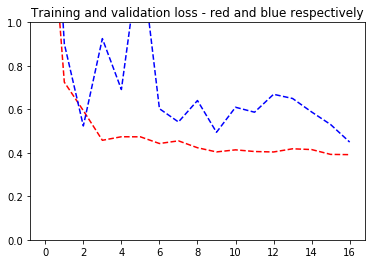

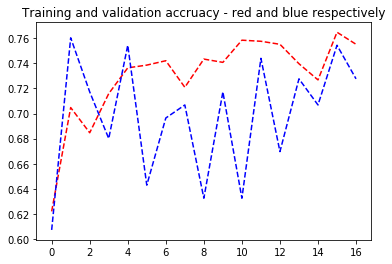

done


In [78]:
#log_dir = 'saved/runs/GroundTruth_cellData/0530_184531/'
saved_dir = 'saved/GroundTruth_cellData/0604_211916'
#saved_dir = 'saved/GroundTruth_maxProjection/0604_202104'
#saved_dir = 'saved/GroundTruth_sumProjection/0604_192331'
config_saved_filename = os.path.join(saved_dir, "config.json")
#os.system('tensorboard --logdir ' + log_dir) cannot use with google VM without paying $$$
viewTraining.graphLoss(saved_dir) #imported from utils

print('done')

In [79]:
def main2(config, resume):
    # setup data_loader instances
    data_loader = get_instance(module_data, 'data_loader_test', config)
    '''
    
    data_loader = getattr(module_data, config['data_loader']['type'])(
        config['data_loader']['args']['data_dir'],
        batch_size=1,
        shuffle=False,
        validation_split=0.0,
        training=False,
        num_workers=2
    )
    '''
    # build model architecture
    model = get_instance(module_arch, 'arch', config)
    print(model)
    print(torch.cuda.get_device_name(0))
    normalized = False

    
    # get function handles of loss and metrics
    loss_fn = getattr(module_loss, config['loss'])
    criterion = loss_fn(None)
    metric_fns = [getattr(module_metric, met) for met in config['metrics']]
    
    # load state dict
    checkpoint = torch.load(resume)
    state_dict = checkpoint['state_dict'] #dictionary of model parameters from saved file
    if config['n_gpu'] > 1:
        model = torch.nn.DataParallel(model)
    model.load_state_dict(state_dict) 
    
    # prepare model for testing
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval() #tells model to ignore dropout and batch normalization
    
    total_loss = 0.0
    total_metrics = torch.zeros(len(metric_fns))
    
    classes = ('class0', 'class1')
    
    with torch.no_grad(): #speed up calculations, unable to perform back propogation
        for i, (data, target) in enumerate(tqdm(data_loader)): #tqdm is a progress bar
            data, target = data.to(device), target.to(device)
            output = model(data)
            #
            # save sample images, or do something with output here
            #
            
            
            if i < 5:
                util.visualizationOutGray(data, output, target, classes, normalized)
                
                
            # computing loss, metrics on test set
            loss = criterion(output, target)
            batch_size = data.shape[0]
            total_loss += loss.item() * batch_size
            if output.is_cuda: output = output.cpu()
            if target.is_cuda: target = target.cpu()
            
            for i, metric in enumerate(metric_fns):
                total_metrics[i] += metric(output, target) * batch_size
        
        plt.show()
                      
    n_samples = len(data_loader.sampler)
    print("num test images = " + str(n_samples))
    log = {'loss': total_loss / n_samples}
    log.update({met.__name__: total_metrics[i].item() / n_samples for i, met in enumerate(metric_fns)})
    for key in log:
        print("{} = {:.4f}".format(key, log[key]))
    #print(log)
    print("My_metric is accuracy")
    
   

In [80]:
#saved_dir = "saved/GroundTruth_cellData/0529_191042/"
resume = os.path.join(saved_dir, "model_best.pth")

print(os.path.isdir(saved_dir))
print(os.path.exists(resume))

#config = torch.load(saved_dir + "config.json")
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

True
True


  0%|          | 0/9 [00:00<?, ?it/s]

deeperModel(
  (layer): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (14): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchNorm2d(512, eps=1e-05, momentum=0

100%|██████████| 9/9 [00:00<00:00, 24.94it/s]


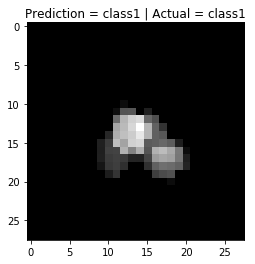

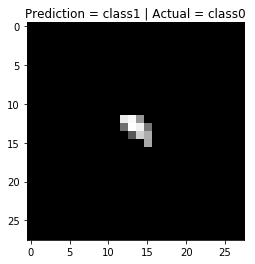

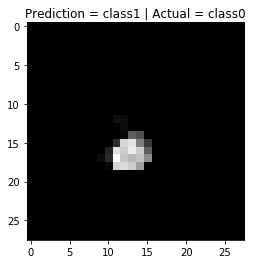

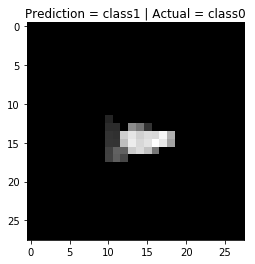

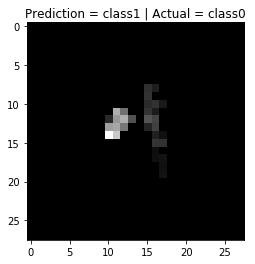

num test images = 83
loss = 0.5453
my_metric = 0.6867
f1 = 0.6363
balanced_accuracy = 0.6543
precision = 0.7280
recall = 0.6867
My_metric is accuracy


In [81]:
#Test
main2(config, resume)